In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 5, 4
rcParams['figure.dpi'] = 200

import torch

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
from scipy.spatial import distance_matrix

In [3]:
n1 = 50

In [4]:
V = 50000

In [5]:
d0 = 5

In [6]:
dtype = torch.float

In [7]:
n = n1*3

In [8]:
import pickle as pkl

In [9]:
Y = pkl.load(open( "multiview_sim_y.pkl", "rb" ))

In [10]:
s_mat = pkl.load( open( "multiview_sim_s_mat.pkl", "rb" )) 

In [11]:
x0 = pkl.load( open( "multiview_sim_x0.pkl", "rb" )) 

In [12]:
km_fit = pkl.load( open( "multiview_sim_init_x_v.pkl", "rb" ) )


In [13]:
W0Oracle_list = pkl.load( open( "multiview_sim_w0_list.pkl", "rb" ) )


In [14]:
g = 10

In [15]:
d = 10

In [16]:
# initialize eta with K-means

ltri_idx = np.tril_indices(n,k=-1)
eta_ini = np.eye(d)[km_fit]

# smoothing
eta_ini = (eta_ini + 1/V) / (1+ d/V)

# eta_ini_dev = torch.tensor(eta_ini,device=device,dtype=dtype)

In [17]:
s_mat.shape

(50000, 11175)

In [18]:
device = torch.device(device= 'cuda:1')
dtype = torch.float

In [19]:
eta = torch.tensor(eta_ini,dtype=dtype,device=device)

In [20]:
s_mat_torch = torch.tensor(s_mat,dtype=dtype,device=device)

In [21]:
lam = np.ones(d)
lam = lam/np.sum(lam)

In [22]:
lam

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [23]:
from sklearn.metrics import normalized_mutual_info_score

In [24]:
normalized_mutual_info_score(km_fit, x0)

/home/shared/anaconda3/envs/leo/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8372006020410202

In [25]:
eta_S = eta.T@ s_mat_torch
eta_1MinusS = eta.T@ (1-s_mat_torch)

In [26]:
W0_list = list()

for l in range(d):
    W0 = torch.rand(n,g, requires_grad=True, device = device, dtype=dtype)
    W0_list.append(W0)

In [27]:
def CrossEntropyTorch(S_ltr, S1m_ltr,P_ltr):
    CEntropy = - S_ltr * torch.log(P_ltr) - S1m_ltr * torch.log(1-P_ltr)
    loss = torch.sum(CEntropy)
    return loss

In [28]:
ltri_idx_torch = torch.tril(torch.ones(n, n),diagonal=-1) == 1

In [29]:
alpha0 = 0.1

In [30]:
tau = 1

In [31]:
from copy import deepcopy 

In [32]:
learning_rate = 1
optimizer = torch.optim.Adam(W0_list, lr=learning_rate)

In [33]:
for t in range(100):
    
    W_list = list()
    P_list = list()

    for l in range(d):
        W = torch.softmax(W0_list[l],1)
        P = W@W.T

        W_list.append(W)
        P_list.append(P)

    loss = 0
    for l in range(d):
        W = W_list[l]
        loss += CrossEntropyTorch(eta_S[l], eta_1MinusS[l], P_list[l][ltri_idx_torch])
    
    l21_penalty = 0    
    
    for l in range(d):
        l21_penalty += tau * torch.sum(torch.sqrt(torch.sum( torch.threshold(torch.log(W_list[l])+4.0,0.0,0.0)**2,0)))    
    
    total_loss =    loss/n + l21_penalty
    
    
    if t % 100 ==0:
        print(t, total_loss.item(), lam)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    total_loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 2696215.25 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [34]:
learning_rate = 1
optimizer = torch.optim.Adam(W0_list, lr=learning_rate)

In [35]:
alpha0 = 0.1

In [36]:
for t in range(50):

    ######################
    ## E Step:

    # Compute Eta
    
    if t % 5 ==0:

        loss_mat = torch.zeros([V,d],device=device)

        P_vec_list=list()
        for l in range(d):
            P_vec = (P_list[l][ltri_idx_torch]).detach()
            loss_mat[:, l] = torch.sum( - s_mat_torch * torch.log(P_vec) - (1- s_mat_torch) * torch.log(1- P_vec), 1 )

        eta = torch.softmax(  - loss_mat + torch.tensor(np.log(lam), device=device, dtype=dtype),1)

        eta_S = eta.T@ s_mat_torch
        eta_1MinusS = eta.T@ (1-s_mat_torch)


    
    ######################
    # M step:
    
    # Compute Lam:

    eta_cpu = eta.cpu().numpy()
    
    lam = (eta_cpu.sum(0)+alpha0-1)/(eta_cpu.sum() + alpha0*d - d)
    lam[lam<0] = 1E-5
    lam /= np.sum(lam)
    
    # Compute W:
    
    W_list = list()
    P_list = list()

    for l in range(d):
        W = torch.softmax(W0_list[l],1)
        P = W@W.T

        W_list.append(W)
        P_list.append(P)

    loss = 0
    for l in range(d):
        W = W_list[l]
        loss += CrossEntropyTorch(eta_S[l], eta_1MinusS[l], P_list[l][ltri_idx_torch])
    
    l21_penalty = 0    
    
    for l in range(d):
        l21_penalty += tau * torch.sum(torch.sqrt(torch.sum( torch.threshold(torch.log(W_list[l])+3.0,0.0,0.0)**2,0)))    
    
    total_loss =    loss/n + l21_penalty
    
    if (t+1) % 100 ==0:
        print(t, total_loss.item() )
        print(lam)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    total_loss.backward()
    
    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

In [37]:
eta_cpu.sum(0)

array([    0.    ,  9877.    ,     0.    , 10114.    ,  9949.    ,
           0.    ,  8341.967 ,  1684.0377, 10034.    ,     0.    ],
      dtype=float32)

In [38]:
np.bincount(x0)

array([ 9877, 10114, 10034, 10026,  9949])

In [39]:
s_mat_torch.shape

torch.Size([50000, 11175])

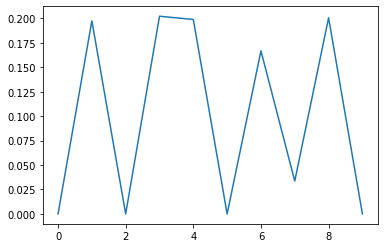

In [40]:
plt.plot(lam)